## Learn Hurst exponent for fractional Brownian Motion


In [1]:
import equinox as eqx
import fbm
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import nets
import optax  # https://github.com/deepmind/optax


jax.config.update("jax_platform_name", "cpu")

In [2]:
n_paths_train = 200
n_paths_test = 50
dt = 1e-2 / 3.0  # 300 time steps
hurst_exponent = jnp.around(jnp.linspace(0.2, 0.8, 7), decimals=7).tolist()

In [3]:
def dataloader(arrays, batch_size, *, key):
    # this taken from equinox documentation
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [4]:
def generate_data(key):
    train_key, test_key = jrandom.split(key)
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    # generate train
    for hurst in hurst_exponent:
        train_key, _ = jrandom.split(train_key)
        X = fbm.generate_fbm(
            hurst=hurst,
            n_paths=n_paths_train,
            dt=dt,
            key=train_key,
        )
        Y = jnp.array([hurst] * n_paths_train)
        X_train.append(X)
        Y_train.append(Y)

    # generate test
    for hurst in hurst_exponent:
        test_key, _ = jrandom.split(test_key)
        X = fbm.generate_fbm(
            hurst=hurst,
            n_paths=n_paths_test,
            dt=dt,
            key=test_key,
        )
        Y = jnp.array([hurst] * n_paths_test)
        X_test.append(X)
        Y_test.append(Y)

    X_train = jnp.concatenate(X_train)
    Y_train = jnp.concatenate(Y_train)
    X_test = jnp.concatenate(X_test)
    Y_test = jnp.concatenate(Y_test)

    return (
        X_train[..., None],
        Y_train[..., None],
        X_test[..., None],
        Y_test[..., None],
    )

In [5]:
seed = 1234
key = jrandom.PRNGKey(seed)
data_key, loader_key, model_key = jrandom.split(key, 3)

In [6]:
X_train, Y_train, X_test, Y_test = generate_data(key=data_key)

In [7]:
model = nets.create_simple_net(
    dim=1,
    signature_depth=3,
    augment_layer_size=(3,),
    augmented_kernel_size=3,
    mlp_width=32,
    mlp_depth=5,
    output_size=1,
    final_activation=jax.nn.sigmoid,
    key=model_key,
)

In [8]:
iter_data = dataloader((X_train, Y_train), batch_size=128, key=loader_key)
optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

In [9]:
@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    assert pred_y.shape[0] == y.shape[0]
    return jnp.mean(jnp.square(pred_y - y))

In [10]:
@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [11]:
test_mse = []
for step, (x, y) in zip(range(500), iter_data):
    loss, model, opt_state = make_step(model, x, y, opt_state)
    loss = loss.item()
    test_mse += [jnp.mean(jnp.square(jax.vmap(model)(X_test) - Y_test)).item()]
    if step % 10 == 0:
        print(f"step={step} \t loss={loss}")

step=0 	 loss=0.041261281818151474
step=10 	 loss=0.03442611172795296
step=20 	 loss=0.027970541268587112
step=30 	 loss=0.02049068734049797
step=40 	 loss=0.014842263422906399
step=50 	 loss=0.01463926862925291
step=60 	 loss=0.008735965006053448
step=70 	 loss=0.0038531338796019554
step=80 	 loss=0.0031830959487706423
step=90 	 loss=0.0017226745840162039
step=100 	 loss=0.0018800266552716494
step=110 	 loss=0.0012469309149309993
step=120 	 loss=0.001055217464454472
step=130 	 loss=0.0011177064152434468
step=140 	 loss=0.0009607287356629968
step=150 	 loss=0.0007560442318208516
step=160 	 loss=0.0006463633617386222
step=170 	 loss=0.0007553303148597479
step=180 	 loss=0.0006547534139826894
step=190 	 loss=0.0005832671886309981
step=200 	 loss=0.0005575551767833531
step=210 	 loss=0.00035020316136069596
step=220 	 loss=0.0004003815120086074
step=230 	 loss=0.00045127380872145295
step=240 	 loss=0.00031438778387382627
step=250 	 loss=0.00036406281287781894
step=260 	 loss=0.000298382830

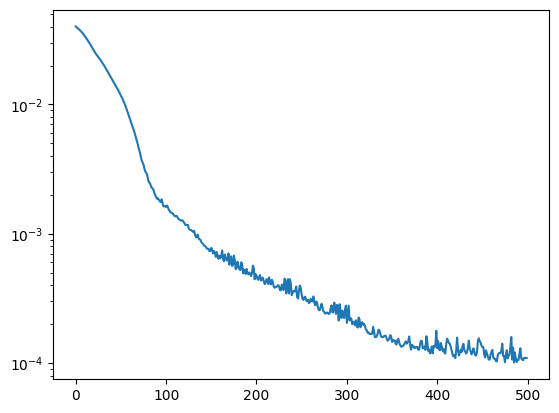

In [12]:
plt.plot(test_mse)
plt.yscale("log")